In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.metrics import confusion_matrix
import pyltr

import data_preprocessing
%matplotlib inline
params = {'axes.labelsize': 14,'axes.titlesize':14, 'text.fontsize': 14, 'legend.fontsize': 14,
          'xtick.labelsize': 13, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 6.5, 4

matplotlib.rcParams.update(params)

from collections import OrderedDict

import utils
from operator import itemgetter

import nDCG
import imp
utils = imp.reload(utils)
nDCG = imp.reload(nDCG)

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Training settings

In [11]:
balance_flag = True
downsampling_rate = 3
learning_rate = 0.03

# Choose cross validation fold k

In [12]:


k=0 # Choose from 0, 1, 2 ,3
train = pd.read_pickle("train_new_"+str(k))
val = pd.read_pickle("val_new_"+str(k))
test = pd.read_pickle("test_new_"+str(k))



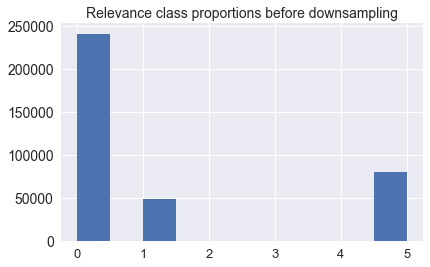

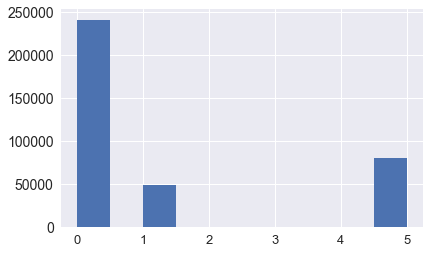

In [20]:
train['relevance'].hist()
plt.title('Relevance class proportions before downsampling')
plt.show()

# Balance the dataset, much faster training
if balance_flag:
    train = utils.balance_dataset(train,downsampling_rate)



In [21]:
#Efi's code for data cleaning
train.shape
selected_features = utils.define_features()

In [22]:
features_to_keep = ['booking_bool', 'srch_id', 'click_bool', 'prop_id', 'relevance']
selected_features = list(set(set(selected_features).difference(features_to_keep)))
all_possible_features = features_to_keep + selected_features

all_possible_features = list(set(all_possible_features))
df_to_train = train.ix[:,all_possible_features]
df_to_val = val.ix[:,all_possible_features]
df_to_test = test.ix[:,all_possible_features]



#Since we've created a new variable that combined those two, there's no need in keeping them
df_to_train.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_val.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_test.drop(['booking_bool', 'click_bool'], axis = 1)

#Rearrange the columns because lambdaMART wants the target variable and the IDs in the first and second column respectively
df_to_train = df_to_train[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_val =  df_to_val[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_test =  df_to_test[['relevance', 'srch_id', 'prop_id']+selected_features]


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


# Downsample majority class

In [23]:
#From dataframes to arrays
trrelevance_arr = np.array(df_to_train['relevance'])
trfeature_arr = np.array(df_to_train[selected_features])
trid_arr = np.array(df_to_train.srch_id)

vrelevance_arr = np.array(df_to_val['relevance'])
vfeature_arr = np.array(df_to_val[selected_features])
vid_arr = np.array(df_to_val.srch_id)

terelevance_arr = np.array(df_to_test['relevance'])
tefeature_arr = np.array(df_to_test[selected_features])
teid_arr = np.array(df_to_test.srch_id)

In [ ]:
rand_seed=0

In [ ]:


#Choose nDCG as metric (k arbitrary number)
metric = pyltr.metrics.NDCG(k=31)

#Use validation set, stop_after arbitrary number
# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    vfeature_arr, vrelevance_arr, vid_arr, metric=metric, stop_after=300)

feats = list(df_to_test[selected_features].columns)
feats

#Use lambdaMART - have to find the best values for the parametes
n_estimators = 50
min_samples_leaf=64
model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    #max_features=0.5,
    #query_subsample=0.5,
    #max_leaf_nodes=10,
    min_samples_leaf=min_samples_leaf,
    verbose=1
)

model.fit(trfeature_arr, trrelevance_arr, trid_arr, monitor=monitor)

tepred = model.predict(tefeature_arr)
print('Random ranking:', metric.calc_mean_random(teid_arr, terelevance_arr))
print('Our model:', metric.calc_mean(teid_arr, terelevance_arr, tepred))

#Need to add Search and Property IDs to the output (easy)
with open('result_statistics_cross_val.txt', mode='a+') as f:
    f.write('%s\t%s\t%s\t%s\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.5f\t%s\t%.0f\t'%(k,rand_seed,len(feats), n_estimators, 
            len(df)/100000,len(df_to_train)/100000, len(df_to_test)/100000,
            learning_rate,downsampling_rate, metric.calc_mean(teid_arr, terelevance_arr, tepred), balance_flag, min_samples_leaf)) 


results_df = df_to_test[['srch_id', 'prop_id', 'relevance']].copy()
results_df['score'] = -1 * tepred

# predictions = list(-1.0*predictions)
recommendations = zip(results_df["srch_id"], results_df["prop_id"], results_df['relevance'], results_df['score'])
utils.write_submission(recommendations, "lambdamart_test.csv")

path_results = "lambdamart_test.csv"
nDCG_result = nDCG.compute_ndcg(path_results)
print(nDCG_result)
with open('result_statistics_our_nDCG_cross_val.txt', mode='a+') as f:
    f.write('%s\t%s\t%s\t%s\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.5f\t%s\t%.0f\t'%(k,rand_seed,len(feats), n_estimators, 
            len(df)/100000,len(df_to_train)/100000, len(df_to_test)/100000,
            learning_rate,downsampling_rate, nDCG_result, balance_flag, min_samples_leaf)) 


 Iter  Train score    Remaining                           Monitor Output 


In [ ]:
import pickle
model_save = pickle.dumps(model)
new_model = pickle.loads(model_save)


In [ ]:
ordinals = np.arange(len(df_to_test))
np.random.shuffle(ordinals)
recommendations = zip(results_df["srch_id"], results_df["prop_id"], results_df['relevance'], ordinals)
utils.write_submission(recommendations, "randomBenchmark_test.csv")
print(ordinals)

In [ ]:
path_results = "randomBenchmark_test.csv"
print(nDCG.compute_ndcg(path_results))